In [45]:
import DriverRisk as dr
import DriverDynamic as dd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import importlib
import pickle
importlib.reload(dr)
importlib.reload(dd)
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
dr.dr_test()

'new test1'

In [77]:
with open('models/xgboost_model.pkl', 'rb') as file:
    xgboost_model = pickle.load(file)
with open('models/xgb_amt_068.pkl', 'rb') as file:
    xgb_amt = pickle.load(file)
# simu_model_1 = dr.load_model_from_checkpoint("models/nn_1.ckpt",'subsim1')
# simu_model_2 = dr.load_model_from_checkpoint("models/nn_2.ckpt",'subsim2')
# simu_model_3 = dr.load_model_from_checkpoint("models/nn_3.ckpt",'subsim3')

In [48]:
driver_df = pd.read_csv('data/telematics.csv')

In [52]:
driver_df

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,182,61,Male,10,Single,Private,824.0,Urban,6213.71,42,...,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0,0.000000
99996,192,48,Male,3,Married,Commute,850.0,Urban,12427.42,32,...,50.0,17.0,10.0,357.0,175.0,48.0,22.0,11.0,0,0.000000
99997,184,50,Male,2,Single,Commute,650.0,Rural,6213.71,31,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0.000000
99998,184,76,Male,2,Married,Private,811.0,Rural,6213.71,58,...,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0,0.000000


In [53]:
#driver_with_claim = driver_df[driver_df["NB_Claim"] >= 1]
driver_with_claim = driver_df
driver_with_claim['NB_Claim'] = driver_with_claim['NB_Claim'].map(lambda x: 1 if x > 0 else 0)

In [54]:
driver_with_claim

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,182,61,Male,10,Single,Private,824.0,Urban,6213.71,42,...,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0,0.000000
99996,192,48,Male,3,Married,Commute,850.0,Urban,12427.42,32,...,50.0,17.0,10.0,357.0,175.0,48.0,22.0,11.0,0,0.000000
99997,184,50,Male,2,Single,Commute,650.0,Rural,6213.71,31,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0.000000
99998,184,76,Male,2,Married,Private,811.0,Rural,6213.71,58,...,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0,0.000000


In [35]:
pos_index = driver_with_claim["NB_Claim"] == 1

In [36]:
#driver_with_claim = driver_with_claim[driver_with_claim["NB_Claim"] == 1]

In [80]:
xgb_amt.feature_names_in_

array(['Duration', 'Insured.age', 'Car.age', 'Credit.score',
       'Annual.miles.drive', 'Years.noclaims', 'Annual.pct.driven',
       'Total.miles.driven', 'Pct.drive.mon', 'Pct.drive.tue',
       'Pct.drive.wed', 'Pct.drive.thr', 'Pct.drive.fri', 'Pct.drive.sat',
       'Pct.drive.sun', 'Pct.drive.2hrs', 'Pct.drive.3hrs',
       'Pct.drive.4hrs', 'Pct.drive.wkday', 'Pct.drive.wkend',
       'Pct.drive.rush am', 'Pct.drive.rush pm', 'Avgdays.week',
       'Accel.06miles', 'Accel.08miles', 'Accel.09miles', 'Accel.11miles',
       'Accel.12miles', 'Accel.14miles', 'Brake.06miles', 'Brake.08miles',
       'Brake.09miles', 'Brake.11miles', 'Brake.12miles', 'Brake.14miles',
       'Left.turn.intensity08', 'Left.turn.intensity09',
       'Left.turn.intensity10', 'Left.turn.intensity11',
       'Left.turn.intensity12', 'Right.turn.intensity08',
       'Right.turn.intensity09', 'Right.turn.intensity10',
       'Right.turn.intensity11', 'Right.turn.intensity12', 'NB_Claim',
       'Insured.se

In [81]:
pred_list = []
amt_list = []
for i in range(1,51):
    print(i)
    driver_processed = dd.apply_reward(driver_with_claim, i)
    driver_processed = dd.process_df(driver_processed)
    X_train = driver_processed.drop("NB_Claim", axis=1)
    y_pred = predict_with_threshold(xgboost_model, X_train, threshold = 0.5)
    X_amt = X_train.copy()
    X_amt['NB_Claim'] = y_pred
    X_amt = X_amt[xgb_amt.feature_names_in_]
    y_amt = xgb_amt.predict(X_amt)
    pred_list.append(sum(y_pred))
    amt_list.append(sum(y_amt))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


Text(0, 0.5, 'Predicted Number of Claims')

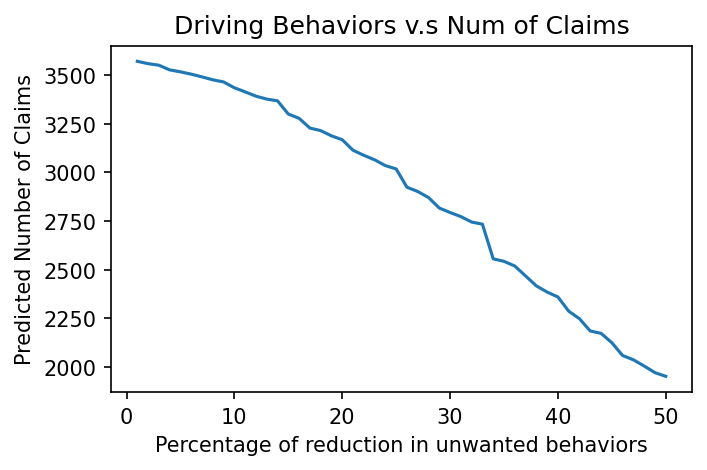

In [83]:
plt.figure(figsize=(5, 3), dpi=150) 
plt.plot(range(1,51), pred_list)
# Add a title
plt.title("Driving Behaviors v.s Num of Claims")

# Add axis labels
plt.xlabel("Percentage of reduction in unwanted behaviors")
plt.ylabel("Predicted Number of Claims")

Text(0, 0.5, 'Predicted Number of Claims')

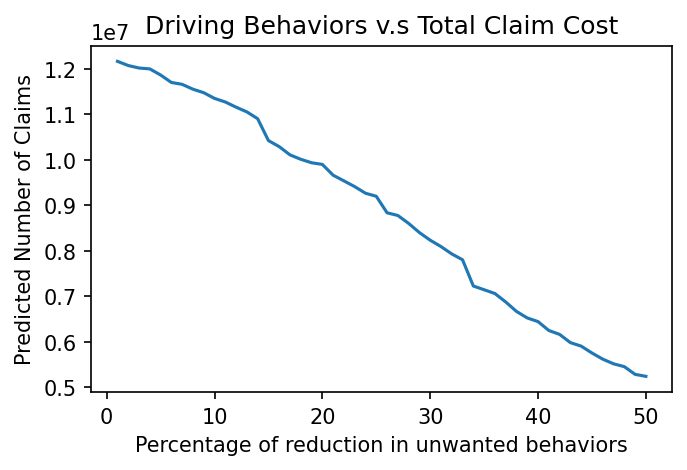

In [84]:
plt.figure(figsize=(5, 3), dpi=150) 
plt.plot(range(1,51), amt_list)
# Add a title
plt.title("Driving Behaviors v.s Total Claim Cost")

# Add axis labels
plt.xlabel("Percentage of reduction in unwanted behaviors")
plt.ylabel("Predicted Number of Claims")

In [55]:
driver_processed = dd.apply_reward(driver_with_claim, 30)
driver_processed = dd.process_df(driver_processed)

In [65]:
pred_list

[]

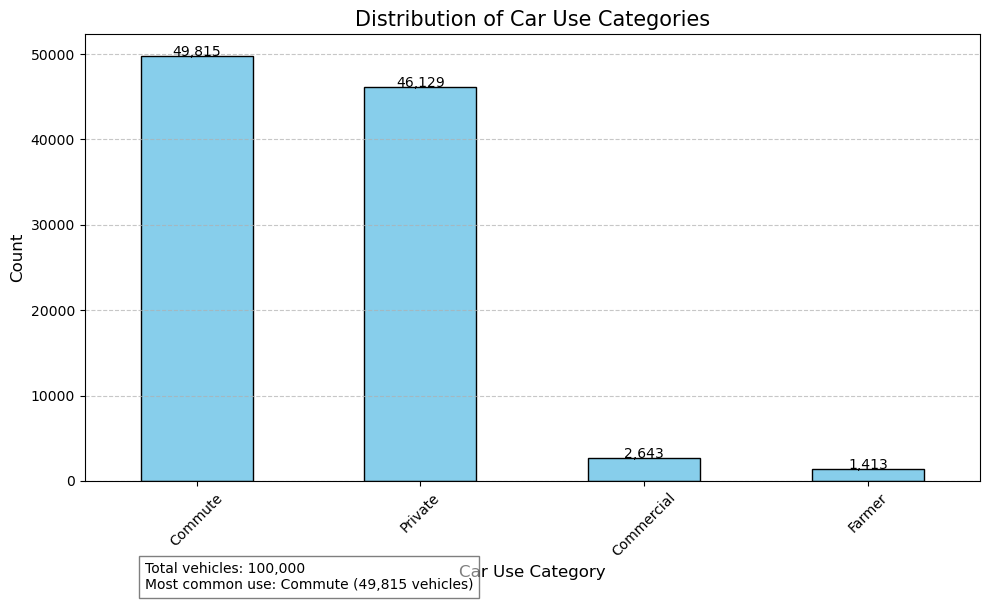

In [87]:
car_use_counts = driver_df['Car.use'].value_counts()

# Create a figure with a specific size
plt.figure(figsize=(10, 6))

# Create the bar plot (histogram for categorical data)
car_use_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Distribution of Car Use Categories', fontsize=15)
plt.xlabel('Car Use Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of each bar
for i, count in enumerate(car_use_counts):
    plt.text(i, count + 0.1, f'{count:,}', ha='center', fontsize=10)

# Improve aesthetics
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a text box with summary statistics
plt.figtext(0.15, 0.01, 
           f'Total vehicles: {car_use_counts.sum():,}\n'
           f'Most common use: {car_use_counts.index[0]} ({car_use_counts.iloc[0]:,} vehicles)',
           bbox=dict(facecolor='white', alpha=0.5), fontsize=10)

# Show the plot
plt.show()






In [57]:
X_train = driver_processed.drop("NB_Claim", axis=1)
y_train = driver_processed["NB_Claim"]

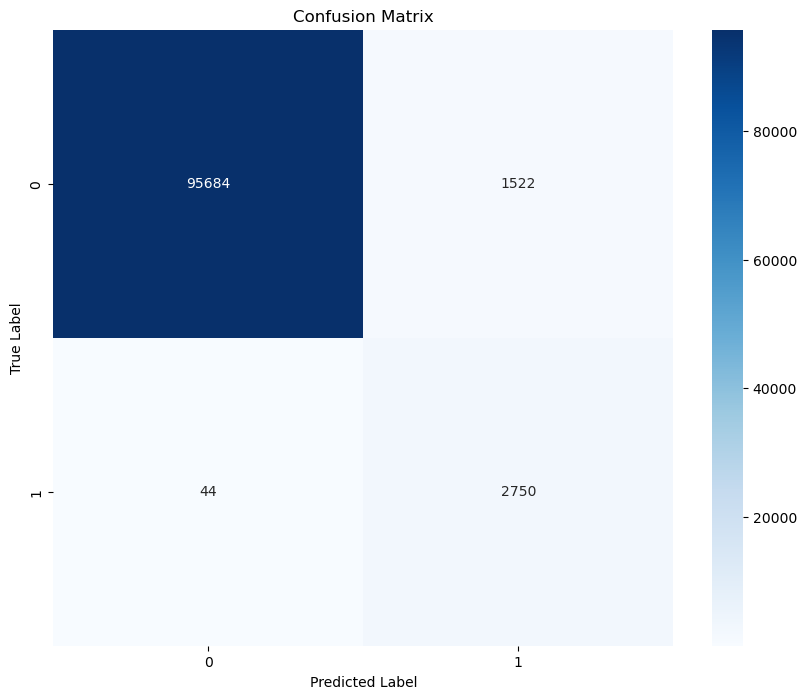

In [58]:
def predict_with_threshold(model, X, threshold=0.4):
    # Get probability predictions
    y_pred_proba = model.predict_proba(X)[:, 1]
    # Apply threshold
    return (y_pred_proba >= threshold).astype(int)

y_pred = predict_with_threshold(xgboost_model, X_train, threshold = 0.5)

# Create and plot confusion matrix
cm = confusion_matrix(y_pred, np.array(y_train))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [90]:
100000 * 500 * 0.05

2500000.0

In [62]:
report = classification_report(y_pred,y_train, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(3)  # Round to 3 decimal places

# Plot classification report as a heatmap
# plt.figure(figsize=(12, 6))
# sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='RdYlGn', center=0.85)
# plt.title('Classification Report Heatmap')
# plt.show()

# Print the numerical classification report
print("\nClassification Report:")
print(classification_report(y_pred,y_train, output_dict=True))


Classification Report:
{'0': {'precision': 0.9995403643657028, 'recall': 0.9843425302964838, 'f1-score': 0.99188323468129, 'support': 97206.0}, '1': {'precision': 0.6437265917602997, 'recall': 0.984251968503937, 'f1-score': 0.7783753184262666, 'support': 2794.0}, 'accuracy': 0.98434, 'macro avg': {'precision': 0.8216334780630012, 'recall': 0.9842972494002105, 'f1-score': 0.8851292765537784, 'support': 100000.0}, 'weighted avg': {'precision': 0.9895989275591078, 'recall': 0.98434, 'f1-score': 0.9859178235011247, 'support': 100000.0}}


In [35]:
##nn prediction
driver_features = driver_processed.drop(columns=["NB_Claim"]).values
driver_target = driver_processed["NB_Claim"].values
with open('models/scaler_1.pkl', 'rb') as f:
    scaler = pickle.load(f)
features = scaler.transform(driver_features)
y_pred, y_output = [], []

with torch.no_grad():
    for i, x in enumerate(features):
        # if driver_target[i] != 1:
        #     continue
        x = torch.tensor(x, dtype=torch.float32)
        y_hat = simu_model_1(x)
        y_output.append(y_hat)
        predictions = (y_hat > 0.5).float().cpu().numpy()
        y_pred.append(predictions)


In [61]:
y_train

0        1
1        1
2        0
3        0
4        0
        ..
99995    0
99996    0
99997    0
99998    0
99999    0
Name: NB_Claim, Length: 100000, dtype: int64

In [102]:
driver_features[pos_index]

array([[366.,  45.,  -1., ...,   0.,   0.,   1.],
       [182.,  44.,   3., ...,   0.,   0.,   1.],
       [366.,  77.,   8., ...,   0.,   1.,   1.],
       ...,
       [328.,  29.,   5., ...,   0.,   1.,   1.],
       [366.,  51.,   0., ...,   0.,   0.,   1.],
       [365.,  46.,   1., ...,   0.,   0.,   1.]])

In [123]:
driver_df = pd.read_csv('data/telematics.csv')
#driver_with_claim = driver_df[driver_df["NB_Claim"] >= 1]
driver_with_claim = driver_df
driver_with_claim['NB_Claim'] = driver_with_claim['NB_Claim'].map(lambda x: 1 if x > 0 else 0)
#driver_with_claim = driver_with_claim[driver_with_claim["NB_Claim"] == 1]
driver_processed = dd.apply_reward(driver_with_claim, 0)
driver_processed = dd.process_df(driver_processed)
driver_features = driver_processed.drop(columns=["NB_Claim"]).values
driver_target = driver_processed["NB_Claim"].values
scaler = StandardScaler()
features_2 = scaler.fit_transform(driver_features)

In [125]:
features_1

array([[ 0.38194254, -0.12574475, -1.51150433, ..., -0.07028523,
        -0.75193655,  0.46332666],
       [-3.04329126, -0.19462301, -0.41292979, ..., -0.07028523,
        -0.75193655,  0.46332666],
       [ 0.38194254,  2.07835966,  0.96028838, ..., -0.07028523,
         1.32989945,  0.46332666],
       ...,
       [-0.3254427 , -1.22779695,  0.13635748, ..., -0.07028523,
         1.32989945,  0.46332666],
       [ 0.38194254,  0.28752483, -1.23686069, ..., -0.07028523,
        -0.75193655,  0.46332666],
       [ 0.36332714, -0.05686649, -0.96221706, ..., -0.07028523,
        -0.75193655,  0.46332666]])

In [126]:
features_2[pos_index].shape

(4272, 51)

In [85]:
sum(np.array(y_pred)[driver_target == 1]) / sum(driver_target == 1)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4272 but corresponding boolean dimension is 100000

In [118]:
driver_df

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,182,61,Male,10,Single,Private,824.0,Urban,6213.71,42,...,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0,0.000000
99996,192,48,Male,3,Married,Commute,850.0,Urban,12427.42,32,...,50.0,17.0,10.0,357.0,175.0,48.0,22.0,11.0,0,0.000000
99997,184,50,Male,2,Single,Commute,650.0,Rural,6213.71,31,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0.000000
99998,184,76,Male,2,Married,Private,811.0,Rural,6213.71,58,...,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0,0.000000


In [21]:
simu_model_1.eval()
device = next(simu_model_1.parameters()).device
data_module, input_size = dr.prepare_data_module(driver_processed, "NB_Claim", 80, oversample_minority=False)
data_module.setup()
dataloader = data_module.whole_dataloader()
# Initialize lists to store predictions and true labels
y_pred = []
y_true = []

# Disable gradient computation for prediction
with torch.no_grad():
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        # Get predictions
        outputs = simu_model_1(x)
        predictions = (outputs > 0.5).float().cpu().numpy()
        y_pred.extend(predictions)
        y_true.extend(y.numpy())

# Convert lists to numpy arrays
y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

Class distribution:
Class 1: 4272 samples (100.00%)


In [24]:
sum(y_pred == 1) / sum(y_true == 1)

0.2663857677902622

In [16]:
sum(y_true[y_true == 1] == y_pred[y_true == 1])/sum(y_true == 1)

0.9461610486891385

sum(driver_processed['NB_Claim'] >= 1)

In [68]:
dataloader.